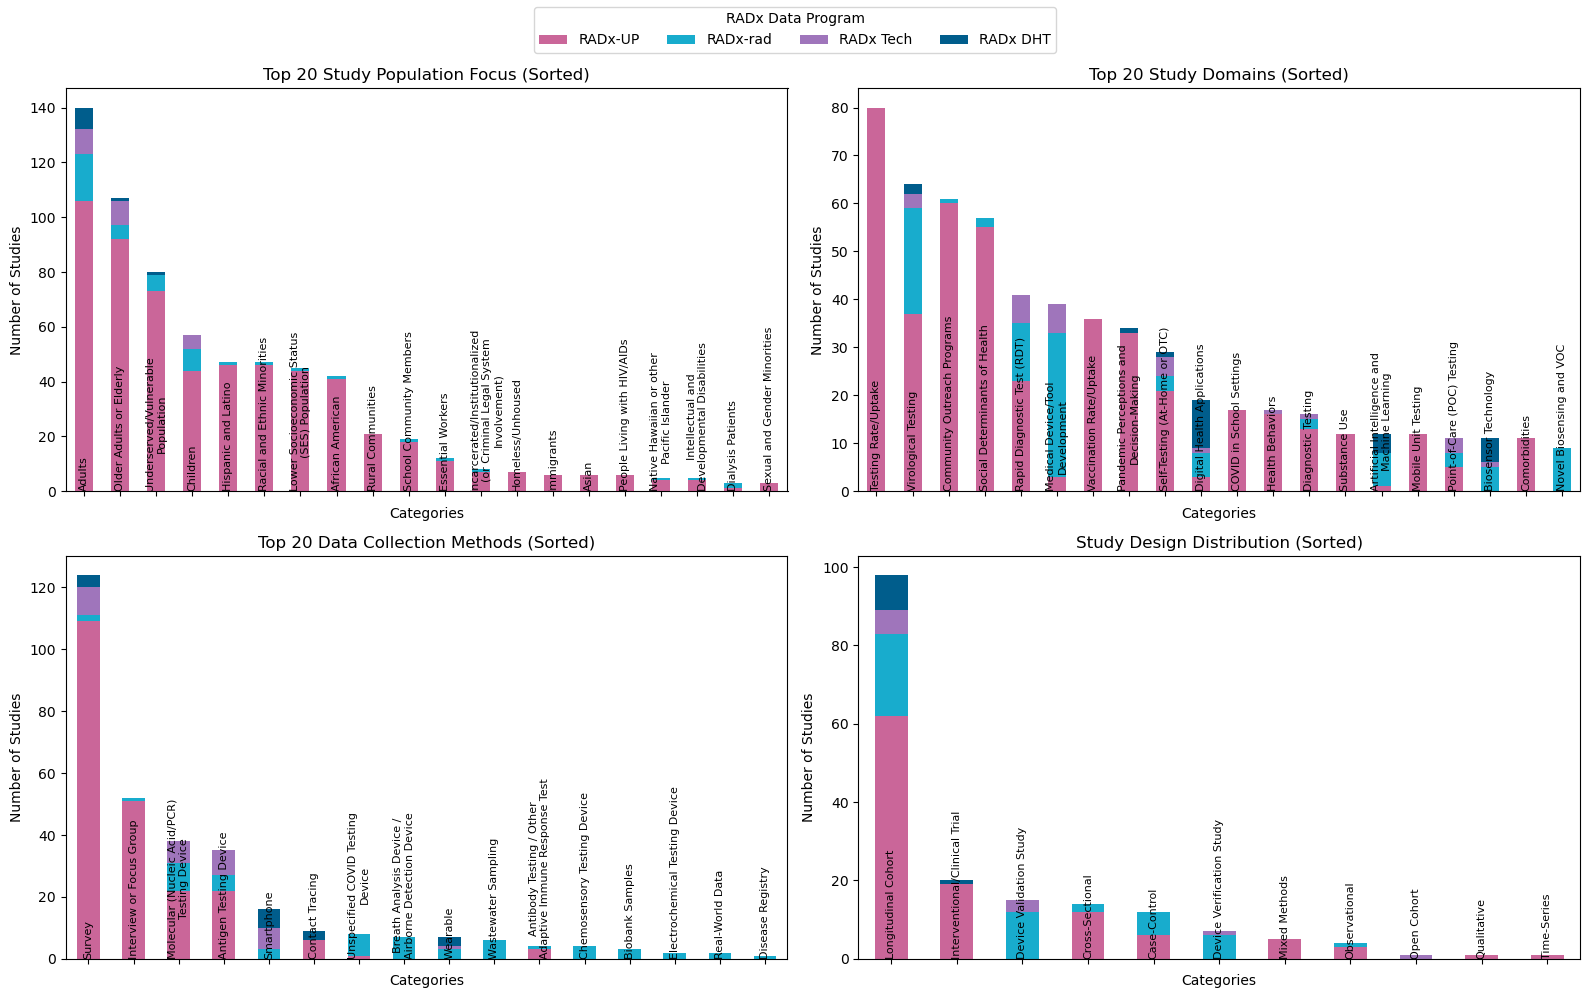

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "StudyExplorerResults.csv"  # Replace with your file path
data = pd.read_csv(file_path, encoding="latin1")

# Process the data
data["Study Population Focus"] = data["Study Population Focus"].str.split("; ")
data["Study Domain"] = data["Study Domain"].str.split("; ")
data["Data Collection Method"] = data["Data Collection Method"].str.split("; ")

# Explode columns to have one value per row for analysis
exploded_population_focus = data.explode("Study Population Focus")
exploded_study_domain = data.explode("Study Domain")
exploded_data_collection = data.explode("Data Collection Method")

# Count occurrences for each category in each field
top_population_focus = exploded_population_focus["Study Population Focus"].value_counts().head(20)
top_study_domain = exploded_study_domain["Study Domain"].value_counts().head(20)
top_data_collection = exploded_data_collection["Data Collection Method"].value_counts().head(20)

# Prepare dataframes for stacked bar chart
def prepare_stacked_data(column_name, top_categories):
    exploded = data.explode(column_name)
    filtered = exploded[exploded[column_name].isin(top_categories.index)]
    return filtered.groupby([column_name, "RADx Data Program"]).size().unstack(fill_value=0)

stacked_population_focus = prepare_stacked_data("Study Population Focus", top_population_focus)
stacked_study_domain = prepare_stacked_data("Study Domain", top_study_domain)
stacked_data_collection = prepare_stacked_data("Data Collection Method", top_data_collection)
stacked_study_design = data.groupby(["Study Design", "RADx Data Program"]).size().unstack(fill_value=0)

# Sort data
def sort_stacked_data(data):
    ordered_columns = data.sum().sort_values(ascending=False).index
    data = data[ordered_columns]
    data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
    return data

sorted_population_focus = sort_stacked_data(stacked_population_focus)
sorted_study_domain = sort_stacked_data(stacked_study_domain)
sorted_data_collection = sort_stacked_data(stacked_data_collection)
sorted_study_design = sort_stacked_data(stacked_study_design)

# Define colors for RADx programs
radx_colors = {
    "RADx Tech": "#9f75bb", 
    "RADx-UP": "#ca6699",   
    "RADx-rad": "#18accd",   
    "RADx DHT": "#005d8c", 
}

# Wrapping function for long labels
def wrap_labels_no_break(labels, max_length=40):
    wrapped_labels = []
    for label in labels:
        if len(label) > max_length:
            words = label.split(' ')
            wrapped_label = ''
            line = ''
            for word in words:
                if len(line) + len(word) + 1 <= max_length:
                    line += (word + ' ')
                else:
                    wrapped_label += line.strip() + '\n'
                    line = word + ' '
            wrapped_label += line.strip()
            wrapped_labels.append(wrapped_label)
        else:
            wrapped_labels.append(label)
    return wrapped_labels

def plot_stacked_bars_with_x_labels(data_list, titles, xlabel, ylabel, colors=None, max_label_length=30):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # Create a 2x2 grid
    axes = axes.flatten()  # Flatten the grid for easy indexing

    for i, data in enumerate(data_list):
        ax = data.plot(kind="bar", stacked=True, ax=axes[i], color=colors, legend=False)
        
        # Wrap x-labels and move them to the bars
        wrapped_labels = wrap_labels_no_break(data.index, max_label_length)
        for tick, label in zip(ax.get_xticks(), wrapped_labels):
            # Position x-labels above the bars
            ax.text(tick, 0, label, ha='center', va='bottom', rotation=90, fontsize=8)
        
        # Hide the default x-tick labels
        ax.set_xticklabels([])
        
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    # Add a single legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="RADx Data Program", loc='upper center', ncol=4)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the legend
    plt.show()

# Data and titles for the grid
data_list = [
    sorted_population_focus,
    sorted_study_domain,
    sorted_data_collection,
    sorted_study_design
]

titles = [
    "Top 20 Study Population Focus (Sorted)",
    "Top 20 Study Domains (Sorted)",
    "Top 20 Data Collection Methods (Sorted)",
    "Study Design Distribution (Sorted)"
]

# Plot all charts with x-labels moved onto the bars
plot_stacked_bars_with_x_labels(
    data_list,
    titles,
    xlabel="Categories",
    ylabel="Number of Studies",
    colors=radx_colors
)